In [73]:
import pandas as pd
from scipy.io import arff
from sklearn import model_selection

from river.linear_model import LogisticRegression, PAClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river.naive_bayes import GaussianNB
from river.neighbors import KNNClassifier
from river import metrics, multiclass, utils
from river.stream import iter_pandas

import matplotlib.pyplot as plt
from tqdm import tqdm


pd.set_option('display.max_columns', None)

In [2]:
data_path = "data/covtypeNorm.arff/covtypeNorm.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df.head()

In [47]:
# convert the bytes format to integer:
df.iloc[:, 10:] = df.iloc[:, 10:].apply(pd.to_numeric)

<ipython-input-47-4248b74a9b54>:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 10:] = df.iloc[:, 10:].apply(pd.to_numeric)


In [49]:
train, test = model_selection.train_test_split(df, test_size=0.05, random_state=1000)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [67]:
def train(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in tqdm(enumerate(stream), total=X_train.shape[0]):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            raw_results.append([model_name, i, acc.get(), acc_rolling.get()])
        # Learn (train)
        model.learn_one(x, y)
    print(f'Samples processed: {i}')
    print(acc)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll'])

In [54]:
pac = PAClassifier()

pac_results = train(stream=iter_pandas(X=X_train, y=y_train), model=pac)

Samples processed: 551960
Accuracy: 36.47%
CohenKappa: -0.00%


In [56]:
ht = HoeffdingTreeClassifier()

ht_results = train(stream=iter_pandas(X=X_train, y=y_train), model=ht)

Samples processed: 551960
accuracy : Accuracy: 66.07%


In [79]:
eft = ExtremelyFastDecisionTreeClassifier(split_criterion='gini')

eft_results = train(stream=iter_pandas(X=X_train, y=y_train), model=eft)

100%|██████████| 551961/551961 [1:33:56<00:00, 97.92it/s]  

Samples processed: 551960
Accuracy: 65.16%


In [78]:
hat = HoeffdingAdaptiveTreeClassifier(split_criterion='gini')

hat_results = train(stream=iter_pandas(X=X_train, y=y_train), model=hat)

100%|██████████| 551961/551961 [24:33<00:00, 374.61it/s]

Samples processed: 551960
Accuracy: 72.83%


In [71]:
lr_ovs = multiclass.OneVsRestClassifier(LogisticRegression())

lr_results = train(stream=iter_pandas(X=X_train, y=y_train), model=lr_ovs)

100%|██████████| 551961/551961 [03:20<00:00, 2754.61it/s]

Samples processed: 551960
Accuracy: 69.52%


In [85]:
gnb = multiclass.OneVsRestClassifier(GaussianNB())
gnb_results = train(stream=iter_pandas(X=X_train, y=y_train), model=gnb)

100%|██████████| 551961/551961 [23:01<00:00, 399.61it/s]

Samples processed: 551960
Accuracy: 48.75%


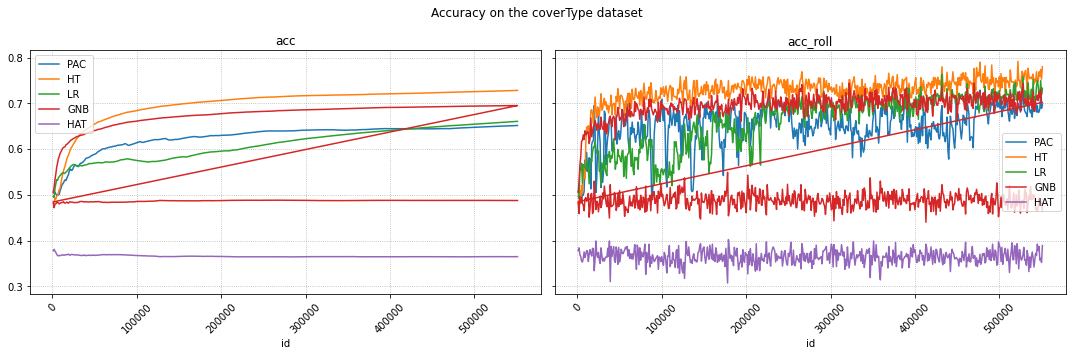

In [86]:
dataset = "coverType"

results = pd.concat([pac_results, ht_results, lr_results, gnb_results, hat_results, eft_results])
results.set_index('id', inplace=True)
grouped = results.groupby('model')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
    grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
    ax.legend(["PAC", "HT", "LR", 'GNB', 'HAT', 'EFT'], loc='best')
    ax.grid(linestyle=':')
fig.suptitle("Accuracy on the %s dataset" % dataset)
plt.tight_layout()
plt.show()

In [58]:
def test(model):
    metric = metrics.Accuracy() + metrics.LogLoss()
    for xi, yi in iter_pandas(X_test, y_test):
        metric = metric.update(yi, model.predict_proba_one(xi))
    return metric

In [59]:
test(ht)

Accuracy: 72.71%, LogLoss: 3.759172304784299


In [77]:
test(lr_ovs)

Accuracy: 71.10%, LogLoss: 1.7346313796806212


In [84]:
test(gnb)

Accuracy: 48.88%, LogLoss: 34.538776394910684


In [ ]:
results_test = []

for metric, ax in zip(['acc_test', 'LogLoss'], axes.flatten()):
    grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
    ax.legend(["PAC", "HT", "LR", 'GNB', 'HAT', 'EFT'], loc='best')
    ax.grid(linestyle=':')